# SCIENCE

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import glob
import gc
import warnings
warnings.filterwarnings('ignore')

In [9]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}

filter_cmap = {
    'Ha': 'gnuplot2',
    'Hb': 'pink',
    'g': 'bone',
    'r': 'hot',
    'i': 'copper'
}

image = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        #hdul.info()
        image[f] = hdul[0].data

with fits.open(file_paths['Ha']) as hdul:
    RA = hdul['RA'].data  
    Dec = hdul['DEC'].data  


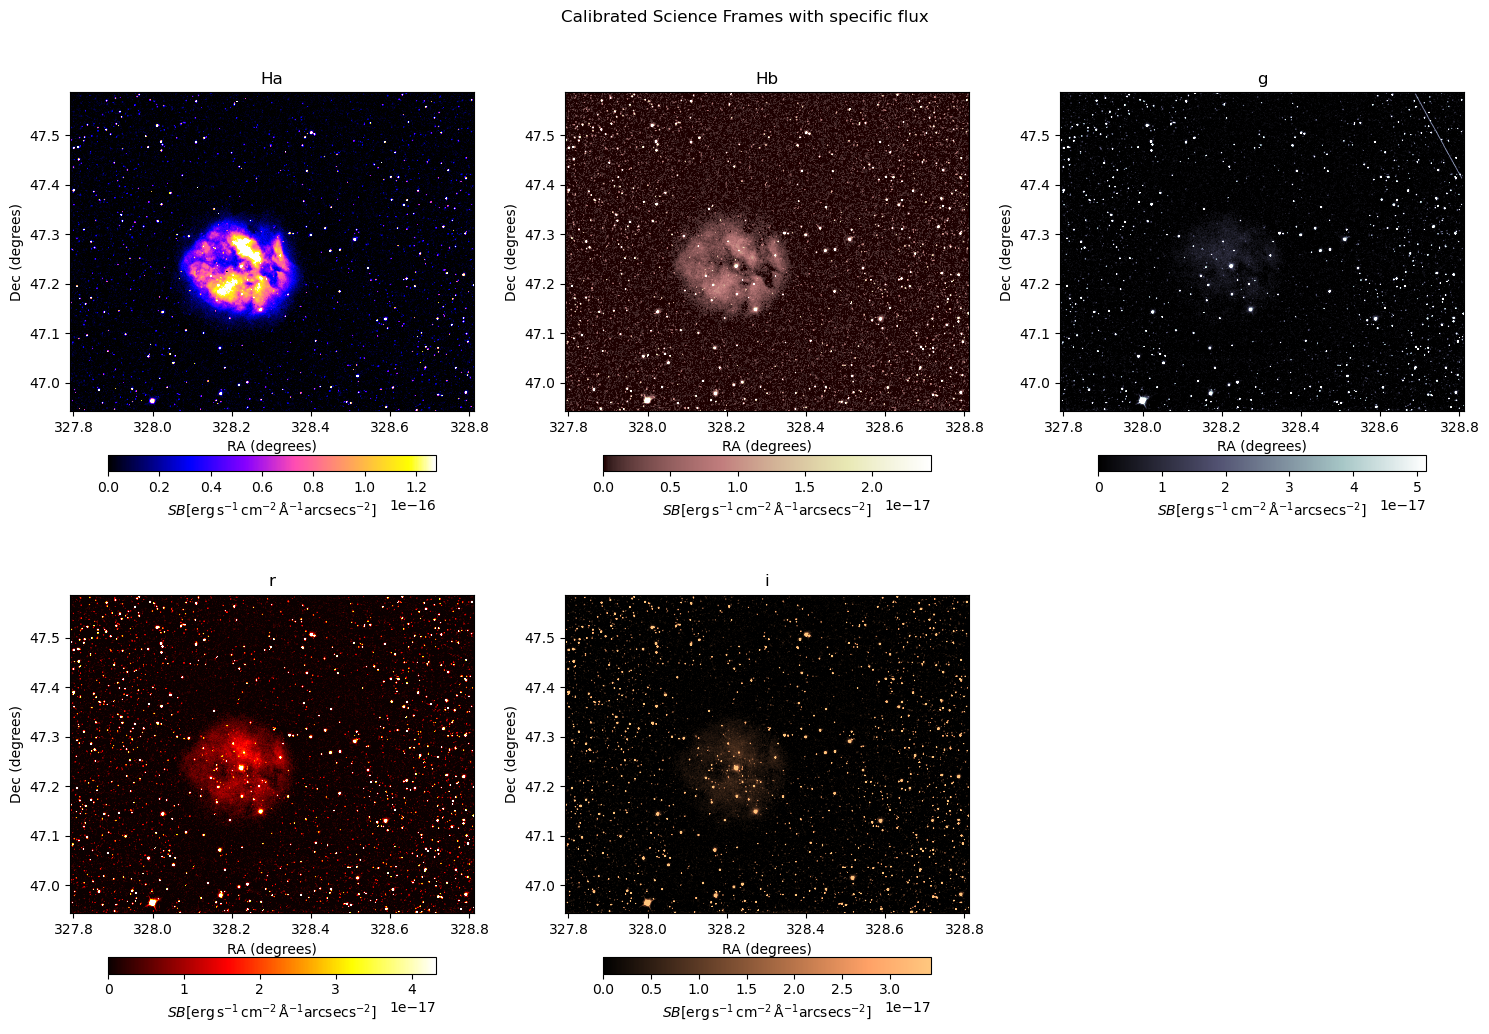

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10.5))
fig.suptitle("Calibrated Science Frames with specific flux")
axes = axes.flatten()

ny,nx = image['Ha'].shape

for i, f in enumerate(filters):
    im = axes[i].imshow(image[f], clim=[0,np.quantile(image[f], 0.99)], cmap=filter_cmap[f],
                        extent=[RA.min(), RA.max(), Dec.min(), Dec.max()], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")
    axes[i].set_title(f)
    axes[i].set_xlabel("RA (degrees)")
    axes[i].set_ylabel("Dec (degrees)")

    axes[i].set_aspect(nx/ny)
    
axes[-1].axis('off')

plt.tight_layout()
plt.show()


## Error extimation

Easiest way to extimate the error is to take for each frame the histogram of the values in each pixel. 

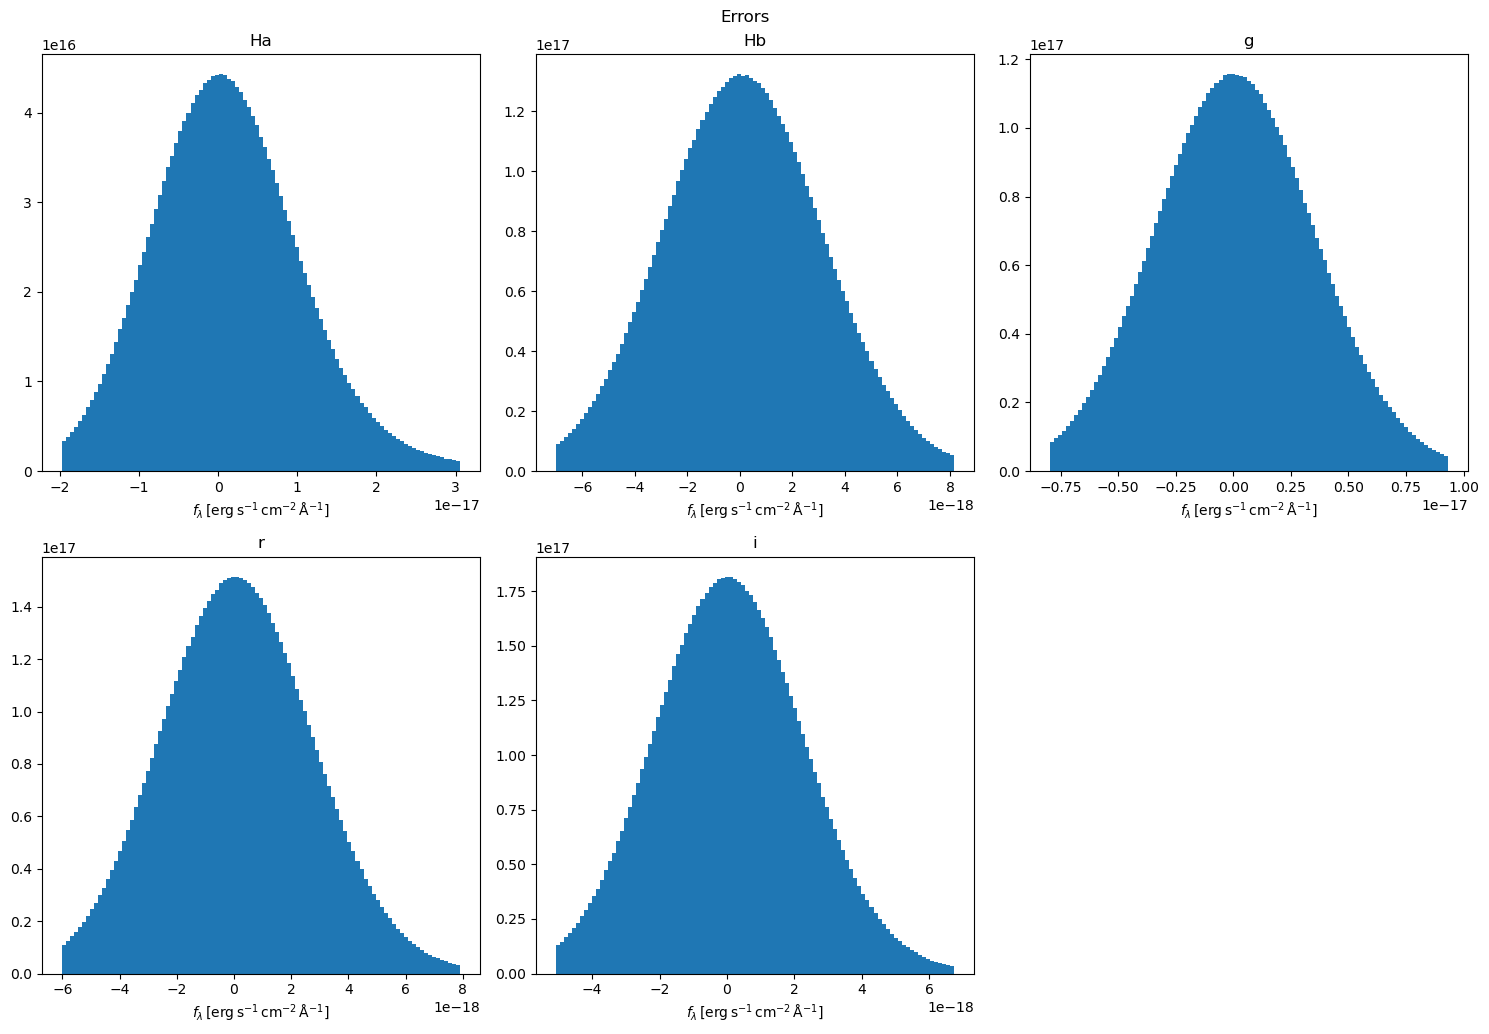

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10.5))
fig.suptitle("Errors")
axes = axes.flatten()

for i, f in enumerate(filters):

    flattened_image = image[f].flatten() 
    bin_edges = np.linspace(np.quantile(flattened_image, 0.01), np.quantile(flattened_image, 0.99), 100)
    axes[i].hist(flattened_image, bins=bin_edges, density=True) 
    axes[i].set_xlabel("$f_\\lambda \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1}}]$")
    axes[i].set_title(f)

axes[-1].axis('off')

plt.tight_layout()
plt.show()


***Radiative transfer equation for optically thin sphere***:

$$dI = -I\alpha ds + j ds$$

For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = \int j  ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2}   j R_\text{cloud}\sin(\theta)d\theta = j 2 R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} sin(\theta)$ is the projected radius in the sky. 

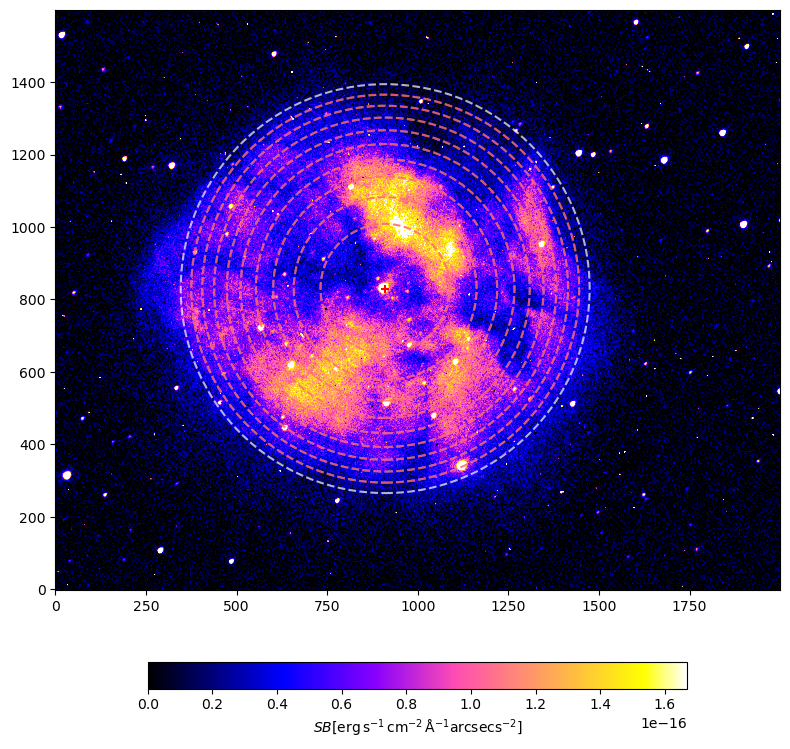

In [42]:

fig, ax = plt.subplots(figsize=(8, 8))
#fig.suptitle("Calibrated Science Frames with specific flux")

x_sx = 1000
x_dx = 3000
y_sx = 800
y_dx = 2400
rectangle = image['Ha'][y_sx:y_dx, x_sx:x_dx]

im = ax.imshow(rectangle, clim=[0,np.quantile(rectangle, 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, ax=ax, location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

# Define the center of the annuli (coordinates of the central star, in pixels)
center_x, center_y = 910, 830
plt.scatter(center_x, center_y,marker='+',c='red')

# Define the inner and outer radii for the circular annuli such that each annulus contains the same number of pixels
num_annuli = 10
N = 100000
R_int = [0.1]
R_ext = []
# Loop to compute the outer radii so that each annulus has the same number of pixels
for i in range(num_annuli):
    # Compute the area needed for this annulus
    r_ext = np.sqrt(N/np.pi + R_int[-1]**2)  # Use the previous outer radius to define the next outer radius
    R_ext.append(r_ext)
    R_int.append(r_ext)

# Generate the list of annuli radii as tuples of inner and outer radii
annuli_radii = [(R_int[i], R_ext[i]) for i in range(num_annuli)]  

from matplotlib.patches import Circle

for inner_r, outer_r in annuli_radii:
    # Draw outer boundary
    circle_outer = Circle((center_x, center_y), outer_r, edgecolor='white', facecolor='none', 
                           linestyle='--', linewidth=1.5, alpha=0.7)
    ax.add_patch(circle_outer)
    # Draw inner boundary
    circle_inner = Circle((center_x, center_y), inner_r, edgecolor='red', facecolor='none', 
                           linestyle='--', linewidth=1.5, alpha=0.5)
    ax.add_patch(circle_inner)


# Average surface brightness in each annulus
from photutils.aperture import CircularAnnulus, aperture_photometry

average_surface_brightness = []

for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)
    
    annulus_flux = aperture_photometry(rectangle, annulus)
    total_flux = annulus_flux['aperture_sum'][0]
    
    # Area of the annular region: A = π * (R_outer^2 - R_inner^2)  # number of pixels????????
    area_annulus = np.pi * (outer_r**2 - inner_r**2)
    avg_surface_brightness = total_flux / area_annulus
    
    #print(f"Average surface brightness in the annulus (r_in={inner_r}, r_out={outer_r}): {avg_surface_brightness}")
    
    # Append the result to the list
    average_surface_brightness.append(avg_surface_brightness)


plt.tight_layout()
plt.show()



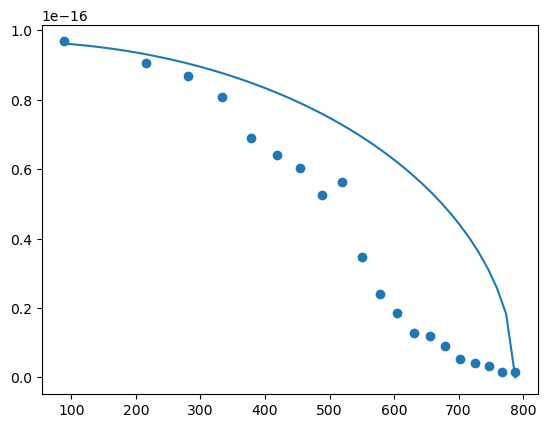

In [41]:
r = [(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]

plt.scatter(r,average_surface_brightness)

x = np.linspace(min(r),max(r))
plt.plot(x,average_surface_brightness[0] * np.sqrt(1-(x/max(r))**2))
#plt.plot(x,average_surface_brightness[0] * (1-np.sin(x/max(r))**2))

***Calzetti***

Absorption: 

$$I_{\text{obs,}\lambda} = I_{\text{int,}\lambda} e^{-\tau_\lambda}$$  for absorption only

$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} \int n_\text{gas}ds$$

In Calzetti notation:

$$\tau_\lambda = \frac{A_{\lambda}}{1.086}=\frac{k(\lambda)E(B-V)}{1.086}$$

Full radiative transfer equation for both emission and absorption:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau_\lambda$$

$S_\lambda$ is the source function and is NOT a black body in this case: actually we are trating the gas + dust cloud as if it was made of only one kind of particle with emissivity the one of the gas and absorption entirely due to gas.

# BALMER DECREMENT

$$L_{obs}(\lambda) = L_{int}(\lambda)10^{-0.4A_\lambda} = L_{int}(\lambda)10^{-0.4k(\lambda)E(B-V)}$$

Reddening: $E(B-V) = (B-V)_{obs}-(B-V)_{int}$

The relationship between the nebular emission-line color excess and the Balmer decrement is given by:

$$E(B - V) = \frac{E(\mathrm{H}\beta - \mathrm{H}\alpha)}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} = \frac{2.5}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} \log_{10} \left[ \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}} \right]$$

where $(k(\lambda_{\mathrm{H}\beta}))$ and $(k(\lambda_{\mathrm{H}\alpha}))$ are the reddening curves evaluated at $H\beta$ and $H\alpha$ wavelengths, respectively. The factor $E(\mathrm{H}\beta - \mathrm{H}\alpha)$ is analogous to the color excess but defined for $H\beta$ and $H\alpha$ instead of the B and V bands. Then, $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}$ is the observed Balmer decrement, and $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}$ is the intrinsic or unreddened Balmer decrement, which is calculated theoretically.

The intrinsic Balmer decrement remains roughly constant for typical gas conditions in star-forming galaxies (see Osterbrock 1989). In our analysis, we assume the value of $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}} = 2.86$, corresponding to a temperature $T = 10^4 \, \mathrm{K}$ and an electron density $n_e = 10^2 \, \mathrm{cm}^{-3}$ for Case B recombination (Osterbrock 1989). This choice is standard for star-forming galaxies in the literature. Thus, the nebular color excess is given by the following equation:

$$E(B - V) = 1.97 \log_{10} \left( \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{2.86} \right)$$

### Case B Recombination:

***Lyman Photons are Reabsorbed***:
When a hydrogen atom recombines with an electron and transitions to the n=1 ground state, it emits a photon in the Lyman series (e.g., Lyman-α). Under Case B, these Lyman photons are absorbed and reprocessed within the gas, instead of escaping.
This reabsorption occurs because the gas is dense enough to be optically thick to ultraviolet photons in the Lyman series.

***Other Transitions are Optically Thin***:
Photons from transitions to levels n>1n (e.g., Hα from n=3→2) can escape the nebula without significant reabsorption.
This results in the prominence of Balmer, Paschen, and other series of hydrogen emission lines in the spectrum.

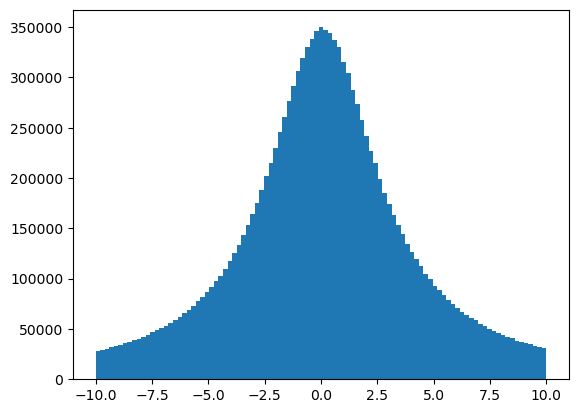

In [8]:
balmer_ratio = images_calib['Ha']/images_calib['Hb']
balmer_ratio_flat = balmer_ratio.flatten()
plt.hist(balmer_ratio_flat,bins=np.linspace(-10,10,100))
plt.show()


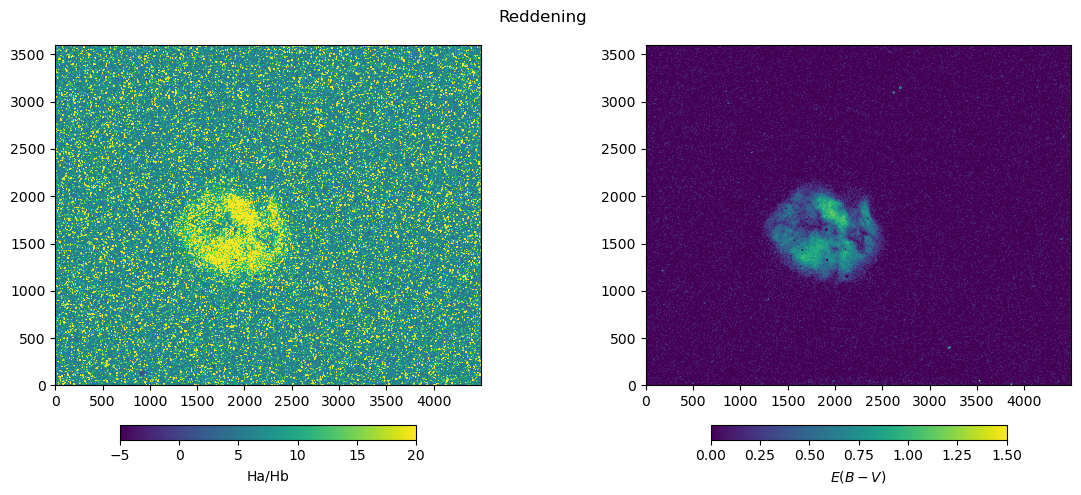

In [15]:
# map of the reddening factor over the nebula

ratio = images_calib['Ha']/images_calib['Hb']
ratio = np.where(ratio>0,ratio,2.86)
E_B_V = 1.97*np.log10(ratio/2.86)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Reddening")

im1 = axes[0].imshow(ratio, cmap='viridis', clim=[-5,20],origin='lower')
fig.colorbar(im1, ax=axes[0], location='bottom', fraction=0.0375, pad=0.1,label="Ha/Hb") #axes[0].set_title("$(H\alpha/H\beta)_{obs}$")

im2 = axes[1].imshow(E_B_V, cmap='viridis', clim=[0, 1.5], origin='lower')
fig.colorbar(im2, ax=axes[1], location='bottom', fraction=0.0375, pad=0.1, label="$E(B-V)$")  #axes[1].set_title("Balmer Decrement ($E(B-V)$)")

plt.tight_layout()
plt.show()



# Stromgen Radius



https://en.wikipedia.org/wiki/Str%C3%B6mgren_sphere






Number of ionizing photons from the star BD+46 3474 -- Double or Multiple Star (21 53 28.849152 +47 15 59.78412) 

B = 10.374
V = 9.632

$$T_\text{surface} = 4600 \text{K}\left( \frac{1}{0.92(B-V)+1.7} + \frac{1}{0.92(B-V)+0.62}  \right)$$  (Ballestreros 2012, Europhysics Letters, 97, 3   http://arxiv.org/abs/1201.1809v2)

In [20]:
B = 10.374
V = 9.632

# T = 4600*(1/(0.92*(B-V)+1.7)+1/(0.92*(B-V)+0.62)) #NOOO

T_star = 28000 # K
R_star = 3.83e11 # cm


# Constants in CGS units
h = 6.62607015e-27  # Planck's constant (erg·s)
c = 3.0e10          # Speed of light (cm/s)
k_B = 1.380649e-16  # Boltzmann's constant (erg/K)
Ly_continuum = 91.2e-7  # Lyman-alpha wavelength (cm)

# Temperature of the star (T_star in Kelvin)
T_star = 32000  # Example: temperature of the star in Kelvin

# Black body function in CGS units
def black_body(w):
    return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)

# Integration over wavelength
from scipy.integrate import quad
photons_area_time_sterad, _ = quad(lambda w: black_body(w) / (h * c / w), 0, Ly_continuum)

S = 4 * np.pi * R_star**2 * photons_area_time_sterad
print("Flux density (CGS):", S)


Flux density (CGS): 3.1756303922787743e+47


/tmp/ipykernel_48229/256964810.py:21: RuntimeWarning: overflow encountered in exp
  return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)


In [21]:
n = 1e2 # nucleon density cm^-3
T_e = 1e4 # electron temperature [K]
beta_2 = 2e-10 * T_e**(-3/4) #recombination rate [cm^3 s^-1] 

# rate of ionizing photons emitted by the star per sec
S_star = S

R_stromgen = (3/(4*np.pi)*S_star/(n**2*beta_2))**(1/3)  # cm

print(R_stromgen)

parsec = 3.086e18 # cm
AU = 1.49e13 # cm

print(R_stromgen/parsec)

distance = 800*parsec # cm (± 80 pc)


3.359209693936352e+18
1.0885319811848193


In [22]:
theta_stromgen_arcsec = R_stromgen/distance * 206265
print(theta_stromgen_arcsec)

angular_size_pixel_TOBI = 0.44 # arcsec per pixel

R_stromgen_detector = theta_stromgen_arcsec / angular_size_pixel_TOBI
print(R_stromgen_detector)

280.6575613738584
637.8580940314964


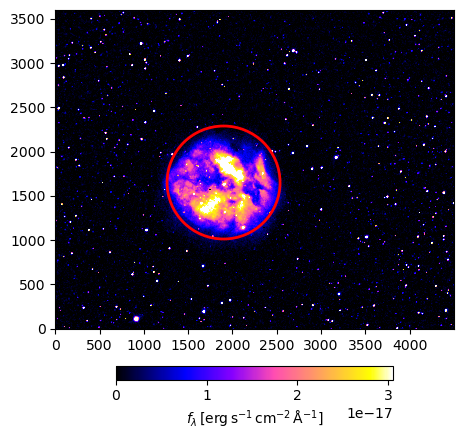

In [42]:

im = plt.imshow(images_calib['Ha'], clim=[0,np.quantile(images_calib['Ha'], 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, location='bottom', fraction=0.0375, pad=0.1, label="$f_\\lambda \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1}}]$")

from matplotlib.patches import Circle

circle = Circle((1900,1650), radius = R_stromgen_detector, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)  # Add the circle to the current axes



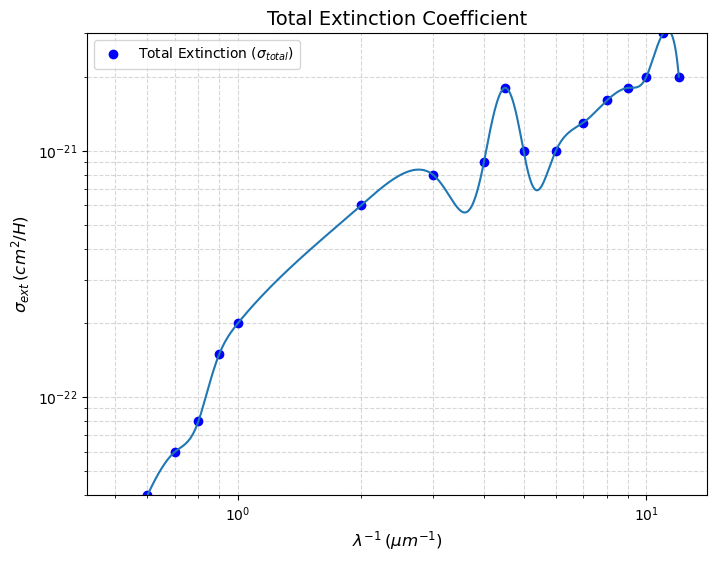

In [23]:
from scipy.interpolate import interp1d

# File format: lambda^-1 sigma_total
data = np.loadtxt("dust_extinction_curve.txt", unpack=True)
lambda_inv, sigma_total = data  # Unpack the columns


# Interpolation: Create an interpolating function
sigma_nu = interp1d(lambda_inv, sigma_total, kind="cubic")  # Cubic interpolation

plt.figure(figsize=(8, 6))
plt.plot(lambda_inv, sigma_total, label="Total Extinction ($\sigma_{total}$)", marker="o", linestyle="", color="blue")
w = np.linspace(min(lambda_inv), max(lambda_inv), 1000)
plt.plot(w,sigma_nu(w))


plt.ylim(4e-23,3e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\lambda^{-1} \\, (\\mu m^{-1})$", fontsize=12)
plt.ylabel("$\\sigma_{ext} \\, (cm^2 / H)$", fontsize=12)
plt.title("Total Extinction Coefficient", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Show the plot
plt.show()


In [ ]:
# takes lambda^-1

def tau_nu(lambda_inv,dust_H_ratio,N_H):
    return sigma_nu(lambda_inv) * dust_H_ratio * N_H
    

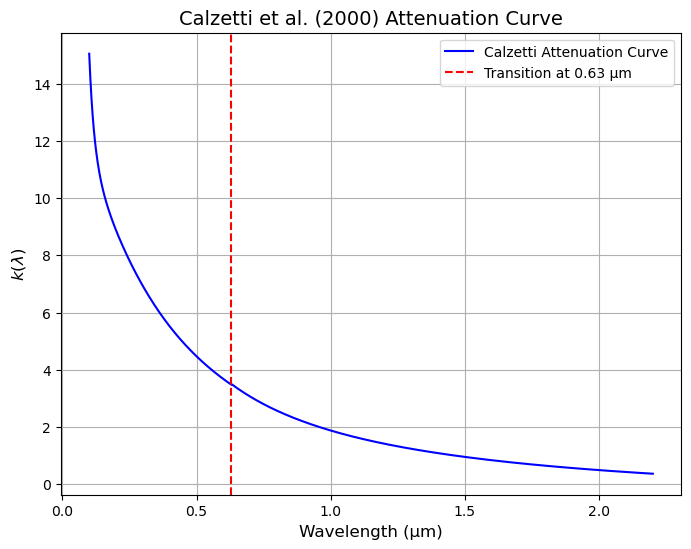

In [24]:
def calzetti_k_lambda(wavelength, R_V=4.05):
    """
    Calculate the Calzetti attenuation curve k(lambda).
    
    Parameters:
    - wavelength: Wavelength in microns (array or scalar).
    - R_V: Total-to-selective extinction ratio (default 4.05).
    
    Returns:
    - k_lambda: Attenuation curve at the given wavelengths.
    """
    wavelength = np.array(wavelength)
    k_lambda = np.zeros_like(wavelength)
    
    # UV regime: λ <= 0.63 μm
    uv_mask = wavelength <= 0.63
    k_lambda[uv_mask] = (
        2.659 * (-2.156 + 1.509 / wavelength[uv_mask] 
                 - 0.198 / wavelength[uv_mask]**2 
                 + 0.011 / wavelength[uv_mask]**3) + R_V
    )
    
    # Optical/NIR regime: λ > 0.63 μm
    optical_mask = wavelength > 0.63
    k_lambda[optical_mask] = (
        2.659 * (-1.857 + 1.040 / wavelength[optical_mask]) + R_V
    )
    
    return k_lambda

# Define wavelength range
wavelengths = np.linspace(0.1, 2.2, 1000)  # 0.1 μm to 2.2 μm
k_values = calzetti_k_lambda(wavelengths)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, k_values, label="Calzetti Attenuation Curve", color="blue")
plt.axvline(0.63, color="red", linestyle="--", label="Transition at 0.63 μm")
plt.xlabel("Wavelength (μm)", fontsize=12)
plt.ylabel("$k(\\lambda)$", fontsize=12)
plt.title("Calzetti et al. (2000) Attenuation Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
